In [1]:
import os
data_path = '/home/nick/Documents/Neural_Networks/Tutorials/Jena_Climate'
fname = os.path.join(data_path, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


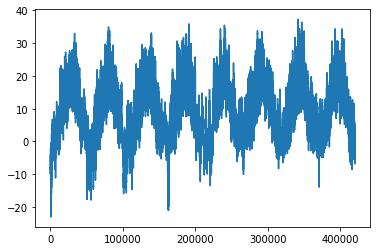

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

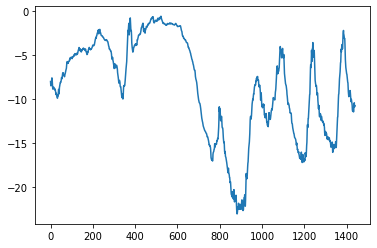

In [3]:
plt.plot(range(1440), temp[:1440])

In [4]:
mean = float_data[:2000000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [5]:
train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [6]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.28969941979609626


In [7]:
baseline_temp_mae = 0.29 * std[1]

In [8]:
baseline_temp_mae

2.5672247338393515

In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import RMSprop

model = Sequential([
    Flatten(input_shape=(lookback // step, float_data.shape[-1])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=RMSprop(), loss='mae')
dense_history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=250)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 5s 11ms/step - loss: 0.6041 - val_loss: 0.1501
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2798 - val_loss: 0.5144
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2555 - val_loss: 0.0915
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2402 - val_loss: 0.1648
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2289 - val_loss: 0.5119
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2199 - val_loss: 0.1918
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2140 - val_loss: 0.1472
Epoch 8/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2062 - val_loss: 0.2131
Epoch 9/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2024 - val_loss: 0.1644
Epoch 10/20
500/500 [==============================] - 5s 11ms/step - loss: 0.1985 - val_lo

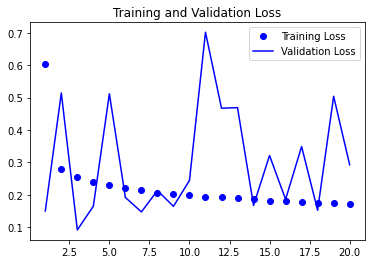

In [10]:
from matplotlib import pyplot as plt

loss = dense_history.history['loss']
val_loss = dense_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Epoch 1/20
500/500 [==============================] - 56s 113ms/step - loss: 0.3075 - val_loss: 0.1033
Epoch 2/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2841 - val_loss: 0.1822
Epoch 3/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2787 - val_loss: 0.4385
Epoch 4/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2740 - val_loss: 0.1734
Epoch 5/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2673 - val_loss: 0.4018
Epoch 6/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2644 - val_loss: 0.3530
Epoch 7/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2609 - val_loss: 0.2586
Epoch 8/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2580 - val_loss: 0.2463
Epoch 9/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2517 - val_loss: 0.1705
Epoch 10/20
500/500 [==============================] - 56s 112ms/step - l

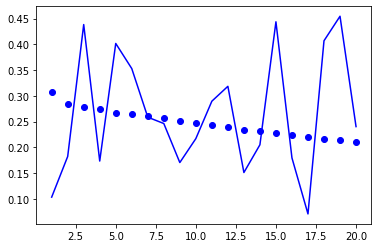

In [11]:
from keras.layers import GRU

model = Sequential([
    GRU(32, input_shape=(None, float_data.shape[-1])),
    Dense(1)
])

model.compile(optimizer=RMSprop(), loss='mae')
rnn_history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=250)

epochs = range(1, len(rnn_history.history['loss']) + 1)

plt.plot(epochs, rnn_history.history['loss'], 'bo')
plt.plot(epochs, rnn_history.history['val_loss'], 'b')
plt.show()